# Extreme Learning Machine

Let's review all of the different ways we've optimized the same problem - classification of MNIST data by comparing each objective function

Linear Least Squares - 2 norm

\begin{gather}
E(\textbf{C}_{\text{obs}}, \textbf{W})=\Vert \textbf{WY} - \textbf{C}_{\text{obs}} \Vert^2
\end{gather}

Linear Classification Softmax - Cross Entropy

\begin{gather}
E(\textbf{C}_{\text{obs}}, \textbf{W})=-\frac{1}{n}\textbf{e}^\top_{n_c}(\textbf{C}_{\text{obs}} \odot \textbf{WY}) \textbf{e}_n + 
\frac{1}{n}\log(\textbf{e}^\top_{n_c}\exp(\textbf{WY}))\textbf{e}_n
\end{gather}

Then for the single layer network, we replace $\textbf{Y}$ with $\textbf{Z}=\sigma(\textbf{KY+be}_{n}^\top)$

So when comparing the single layer networks to the linear scenario, the only difference is that the $\textbf{Y}$ input feature
matrix is transformed into $\sigma(\textbf{KY})$. We apply a matrix $\textbf{K}$ to expand the rows of the matrix (number of features increases to number of hidden nodes), and then change the rank by applying the nonlinear activation function $\sigma$. What deep learning essentially does is increase the rank of the matrix, which is usually an undetermined system, to improve the conditions of the optimization problem (make it convex, for example). The idea of Extreme Learning Machines is that if we can randomize the $\textbf{K}$, then we can just use existing methods for 
solving the linear regression and classification case without having to resort to previous iterative methods like backpropagation for finding the weights for both $\textbf{W}$ and $\textbf{K}$. It removes the optimization for $\textbf{K}$, and let's us just focus on the $\textbf{W}$. 

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib
import scipy.io
import pandas as pd

home_dir = pathlib.Path("/c/Users/thsiao3/Documents/emory_class/MATH789/hw4/")
os.chdir(home_dir)

import ELM

## Peaks Regression

I ran the experiment in a separate script and saved the train and test results in the following .csv files. The ELM class and
experiment code are attached.

In [30]:
data_dir = home_dir / "PeaksRegression.mat"
results_reg = pd.read_csv(home_dir / "ELMReg_results.csv")

In [31]:
Y = scipy.io.loadmat(data_dir)
Ytrain = Y['Ytrain']
Ytest = Y['Ytest']
Ctrain = Y['Ctrain']
Ctest = Y['Ctest']

First visualize the regression data.

Text(0, 0.5, 'X2')

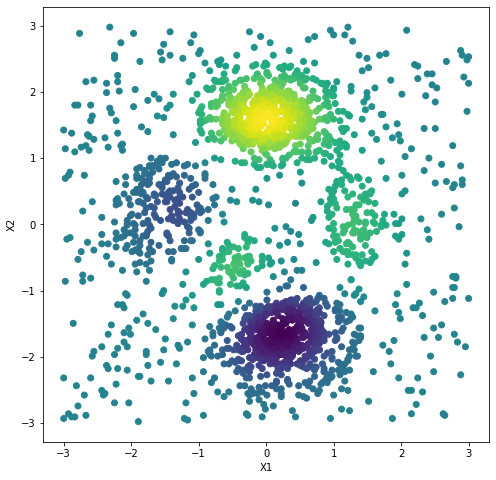

In [32]:
plt.figure(figsize = (8,8))
plt.scatter(Ytrain[0], Ytrain[1], c = Ctrain[0])
plt.xlabel("X1")
plt.ylabel("X2")

List of activation functions considered

\begin{gather}
\text{identity}(x) = x \\\\ 
\text{logistic}(x)=\frac{e^x}{1+e^x} \\\\
\text{tanh}(x) = \frac{e^x-e^{-x}}{e^x+e^{-x}} \\\\
\text{relu}(x) = \text{max}(x,0) \\\\
\text{swish}(x) = \frac{xe^x}{1+e^x}
\end{gather}

<Figure size 1440x720 with 0 Axes>

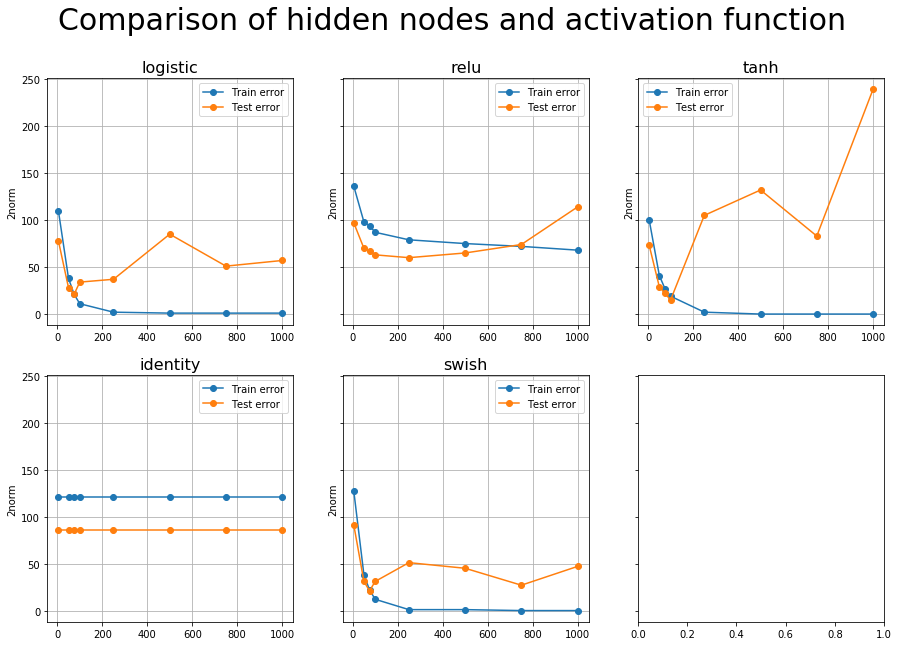

In [33]:
n = len(results_reg.activation.unique())
f = plt.figure(figsize=(20, 10))
f, axs = plt.subplots(2, round(n/2)+1, figsize=(15,10), sharey=True)
f.suptitle('Comparison of hidden nodes and activation function', fontsize=30)
for k in range(n):
    fun = results_reg.activation.unique()[k]
    temp = results_reg[results_reg.activation == fun]
    ax = axs.ravel()[k]
    ax.set_title("{}".format(fun), fontsize=16)
    ax.plot(temp['m'], temp['train_error'], marker='o', label='Train error')
    ax.plot(temp['m'], temp['test_error'], marker='o', label='Test error')
    ax.legend()
    ax.grid()
    ax.set_ylabel('2norm')

In [79]:
results_reg[results_reg['test_error'] == results_reg['test_error'].min()]

,m,activation,train_error,test_error
17,100,tanh,19,15


As the number of hidden nodes increases, training accuracy almost always tends towards zero, except in the identity activation
and relu activation. The identity makes sense because it does not change the rank of the feature matrix, so you would not 
expect the error of the solution to be different. 

Testing accuracy is a different story. For each activation function besides the identity, testing error first decreases, and
then increases, sometimes substantially after a certain threshold. This is do to the model beginning to overfit and pay 
too much attention to noise in the data.

I ended up choosing the tanh function because it yielded the lowest test accuracy out of all hidden node and activation function combinations. It also has the nice property of being bounded between -1 and 1. 

In [104]:
def true_function(x,y):
    return 3*(1-x)**2*np.exp(-x**2-(y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3*np.exp(-(x+1)**2 - y**2)

In [134]:
xy = np.meshgrid[-3:3.1:0.1, -3:3.1:0.1]

TypeError: 'function' object is not subscriptable

In [133]:
xy

array([[[-3. , -3. , -3. , ..., -3. , -3. , -3. ],
        [-2.9, -2.9, -2.9, ..., -2.9, -2.9, -2.9],
        [-2.8, -2.8, -2.8, ..., -2.8, -2.8, -2.8],
        ...,
        [ 2.8,  2.8,  2.8, ...,  2.8,  2.8,  2.8],
        [ 2.9,  2.9,  2.9, ...,  2.9,  2.9,  2.9],
        [ 3. ,  3. ,  3. , ...,  3. ,  3. ,  3. ]],

       [[-3. , -2.9, -2.8, ...,  2.8,  2.9,  3. ],
        [-3. , -2.9, -2.8, ...,  2.8,  2.9,  3. ],
        [-3. , -2.9, -2.8, ...,  2.8,  2.9,  3. ],
        ...,
        [-3. , -2.9, -2.8, ...,  2.8,  2.9,  3. ],
        [-3. , -2.9, -2.8, ...,  2.8,  2.9,  3. ],
        [-3. , -2.9, -2.8, ...,  2.8,  2.9,  3. ]]])

In [80]:
model_reg = ELM.ELM()
model_reg.fit(Ytrain=Ytrain, Ctrain=Ctrain, m=100, sigma=np.tanh, type="reg")

In [81]:
X = np.arange(-3,3.1,.05)
Y = np.arange(-3,3.1,.05)
Grid = np.array([np.array([x, y]) for x in X for y in Y]).T
preds = model_reg.predict(Grid)

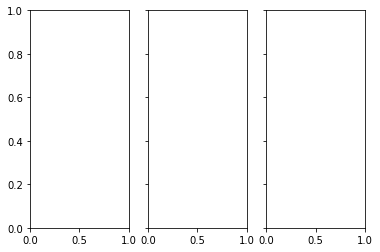

In [100]:
fig, ax = plt.subplots(1, 3, sharex='col', sharey='row')

Text(0.5, 1.0, 'Model output')

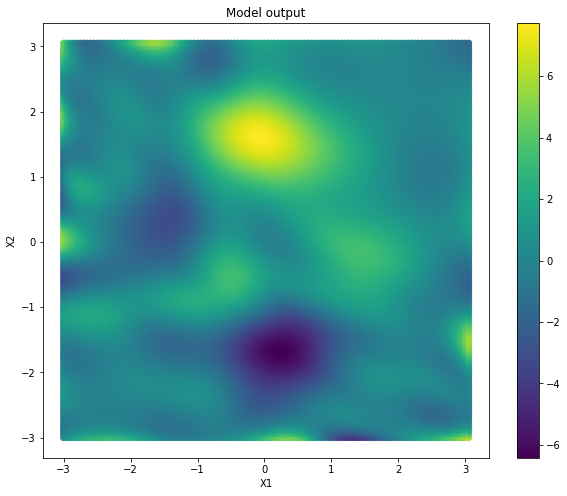

In [88]:
plt.figure(figsize = (10,8))
#plt.scatter(Ytrain[0], Ytrain[1], c = Ctrain[0])
plt.scatter(Grid[0], Grid[1], c = preds[0])
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar()
plt.title('Model output')

In [110]:
?np.apply_along_axis

In [114]:
Grid.shape

(2, 14884)

In [117]:
output = np.apply_along_axis(true_function, 0, Grid)

In [121]:
x = np.linspace(0, 10, 1000)
I = np.sin(x) * np.cos(x[:, np.newaxis])

Text(0.5, 1.0, 'Model output')

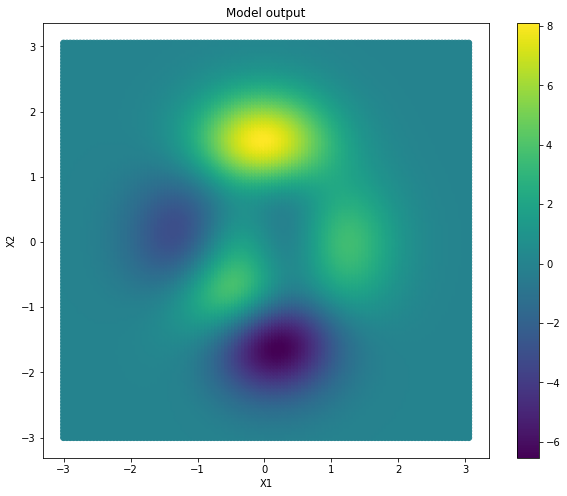

In [120]:
plt.figure(figsize = (10,8))
#plt.scatter(Ytrain[0], Ytrain[1], c = Ctrain[0])
plt.scatter(Grid[0], Grid[1], c = output)
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar()
plt.title('Model output')

Text(0.5, 1.0, 'Model output')

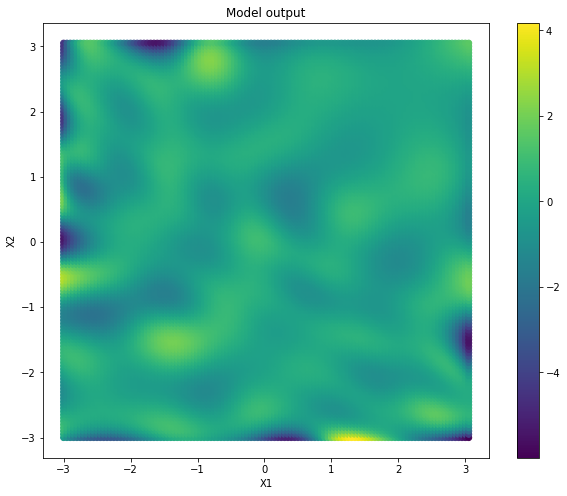

In [119]:
plt.figure(figsize = (10,8))
#plt.scatter(Ytrain[0], Ytrain[1], c = Ctrain[0])
plt.scatter(Grid[0], Grid[1], c = output - preds[0])
plt.xlabel("X1")
plt.ylabel("X2")
plt.colorbar()
plt.title('Model output')

## Peaks Classification

In [135]:
data_dir = home_dir / "PeaksClassification.mat"
results_class = pd.read_csv(home_dir / "ELMClass_results.csv")

Y = scipy.io.loadmat(data_dir)
Ytrain = Y['Ytrain']
Ytest = Y['Ytest']
Ctrain = Y['Ctrain']
Ctest = Y['Ctest']

model_reg = ELM.ELM()
model_reg.fit(Ytrain=Ytrain, Ctrain=Ctrain, m=100, sigma=np.tanh, type="class")

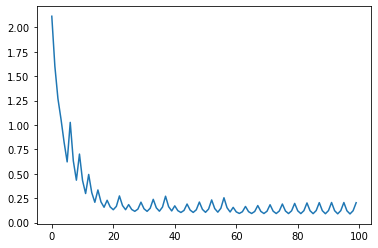

In [139]:
plt.plot(model_reg.grad_norm)

Text(0, 0.5, 'X2')

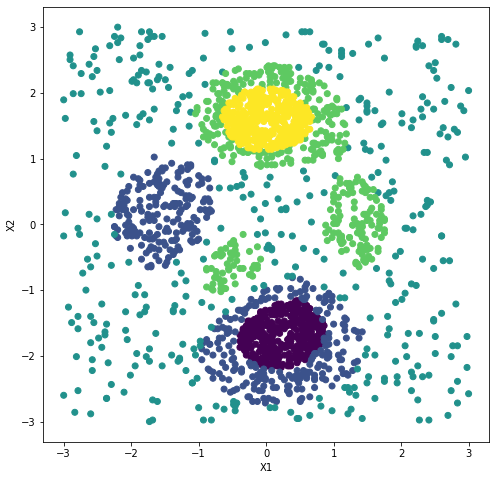

In [12]:
plt.figure(figsize = (8,8))
plt.scatter(Ytrain[0], Ytrain[1], c = np.argmax(Ctrain, 0))
plt.xlabel("X1")
plt.ylabel("X2")

<Figure size 1440x720 with 0 Axes>

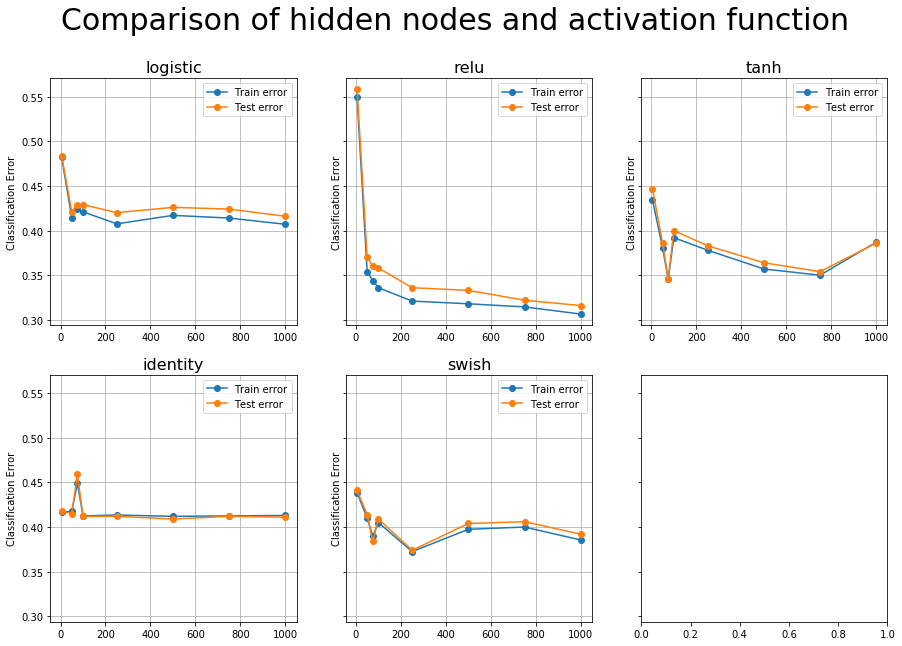

In [13]:
n = len(results_class.activation.unique())
f = plt.figure(figsize=(20, 10))
f, axs = plt.subplots(2, round(n/2)+1, figsize=(15,10), sharey=True)
f.suptitle('Comparison of hidden nodes and activation function', fontsize=30)
for k in range(n):
    fun = results_class.activation.unique()[k]
    temp = results_class[results_class.activation == fun]
    ax = axs.ravel()[k]
    ax.set_title("{}".format(fun), fontsize=16)
    ax.plot(temp['m'], temp['train_error'], marker='o', label='Train error')
    ax.plot(temp['m'], temp['test_error'], marker='o', label='Test error')
    ax.legend()
    ax.grid()
    ax.set_ylabel('Classification Error')